# Melb PTV Datathon 2018: Data Wrangling (Flinders vers)


Intro:
Just grab the parent route data from the card data and do some simple visualisations


Date: 25/9/2018

Version: 0.11

Environment: Python 3.5.2 and Jupyter notebook

Libraries used: 
    pandas, re, string, os, gzip, numpy, re, datetime, seaborn, matplotlibe, geopy

## quick links
- <a href='#import2'>Import files and libraries</a>
- <a href='#hourly1'>look at frequencies on route by hour of day</a>
- <a href='#window'>Create frequency table for time windows of 30 mins</a>
- <a href='#normalise'>Normalise frequencies for unity display</a>
- <a href='#file'>Save to file</a>


##  Import datafiles and python libraries<a id='import2'></a>

In [1]:
# Import the libraries needed to read and report on data files
import pandas as pd
import re
import string
import os 
import gzip
import numpy as np
import datetime as dt
# import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import geopy.distance as distance
import matplotlib.pyplot as plt
import matplotlib.cm
import peakutils
from mpl_toolkits.basemap import Basemap
from random import randint

In [2]:
# code is working for this filtering
myYears = ['2018']
# search for files from root directory down
mypath = "./data"

In [3]:
colNames= ('StopID', 'SourceSystem', 'name','location','StopType','Suburb','PostCode','City','Council','Region','Lat','Long','LatTolerance', 'LongTolerance')
dfStops = pd.DataFrame()
with open("new_Stop_Data.txt",'r',encoding = "ISO-8859-1") as f:
    dfStops = pd.read_table(f, delimiter='\t', names = colNames, dtype={'StopID':np.int64,  'Region':'category'})
    print('The dfStops dataframe has ' + str(dfStops.shape) + ' rows and columns with the following column names and data types.')
    dfStops.dtypes

The dfStops dataframe has (33584, 14) rows and columns with the following column names and data types.


In [4]:
# get lat long of flinders st station
cLat = dfStops[dfStops['StopID']==19854].Lat.unique()
cLong= dfStops[dfStops['StopID']==19854].Long.unique()
cLatLong = [cLat[0],cLong[0]]


# create tuple of lat, long to make manipulation easier
dfStops['LatLong'] = dfStops[['Lat','Long']].apply(tuple,axis=1)
dfStops['cDist']=dfStops.apply(lambda row: distance.distance(cLatLong,row['LatLong']).km,axis=1 )
dfStops.cDist.describe()

count    33584.000000
mean       176.100316
std       1310.931590
min          0.000000
25%         13.800436
50%         26.472064
75%         64.190996
max      14499.815647
Name: cDist, dtype: float64

In [5]:
# don't run this for flinders
flindersStops = dfStops[dfStops['cDist']<.2].StopID.unique().astype(str)
flindersStops

array(['17850', '17877', '18089', '18090', '18175', '18176', '19499',
       '19516', '19685', '19854', '22238', '24117', '24119', '39073',
       '39074', '39075', '39076', '39077', '39078', '39080', '39081',
       '41082', '41393', '45607', '62009', '62013', '62031', '62527',
       '62531', '62540', '62548', '62585', '62721', '63018', '64404',
       '65053', '65054'], dtype='<U21')

In [6]:
len(flindersStops)

37

In [7]:
# Walk through directories to collate all  gz (compressed) filenames

fnames = []
fullnames = []
for root, dirs,files in os.walk(mypath):
    for f in files:
        if "gz" in f:
            fnames.append(os.path.join(root,f).split('/'))
            fullnames.append(os.path.join(root,f)) 

# put files names in a dataframe
allFiles = pd.DataFrame(fnames,columns=['Root','Subdir','Sample','ScanType','Year','Week','fName'])
allFiles['FullName'] = fullnames

allFiles.sample(10)

,Root,Subdir,Sample,ScanType,Year,Week,fName,FullName
55,.,data,Samp_0,ScanOffTransaction,2016,Week36,QID3528705_20180713_04236_0.txt.gz,./data/Samp_0/ScanOffTransaction/2016/Week36/Q...
607,.,data,Samp_1,ScanOnTransaction,2018,Week14,QID3533245_20180713_40008_0.txt.gz,./data/Samp_1/ScanOnTransaction/2018/Week14/QI...
74,.,data,Samp_0,ScanOffTransaction,2016,Week53,QID3529275_20180713_05238_0.txt.gz,./data/Samp_0/ScanOffTransaction/2016/Week53/Q...
627,.,data,Samp_1,ScanOnTransaction,2018,Week9,QID3533086_20180713_35510_0.txt.gz,./data/Samp_1/ScanOnTransaction/2018/Week9/QID...
189,.,data,Samp_0,ScanOnTransaction,2016,Week15,QID3531287_20180713_23539_0.txt.gz,./data/Samp_0/ScanOnTransaction/2016/Week15/QI...
410,.,data,Samp_1,ScanOffTransaction,2017,Week25,QID3529765_20180713_10729_0.txt.gz,./data/Samp_1/ScanOffTransaction/2017/Week25/Q...
477,.,data,Samp_1,ScanOnTransaction,2015,Week33,QID3530883_20180713_20948_0.txt.gz,./data/Samp_1/ScanOnTransaction/2015/Week33/QI...
368,.,data,Samp_1,ScanOffTransaction,2016,Week35,QID3528692_20180713_04200_0.txt.gz,./data/Samp_1/ScanOffTransaction/2016/Week35/Q...
261,.,data,Samp_0,ScanOnTransaction,2017,Week32,QID3532464_20180713_33128_0.txt.gz,./data/Samp_0/ScanOnTransaction/2017/Week32/QI...
612,.,data,Samp_1,ScanOnTransaction,2018,Week19,QID3533376_20180713_40515_0.txt.gz,./data/Samp_1/ScanOnTransaction/2018/Week19/QI...


In [8]:
allFiles[allFiles['Year']=='2018'].describe()

,Root,Subdir,Sample,ScanType,Year,Week,fName,FullName
count,114,114,114,114,114,114,114,114
unique,1,1,9,2,1,25,50,114
top,.,data,Samp_1,ScanOnTransaction,2018,Week26,QID3530491_20180713_14034_0.txt.gz,./data/Samp_1/ScanOffTransaction/2018/Week20/Q...
freq,114,114,50,57,114,18,9,1


In [40]:
# create list for all weeks in specified year
allWeeks = allFiles[allFiles['Year'].isin(myYears)].Week.unique()

In [41]:
# set type of scan by the filename
allFiles['OnOff'] = allFiles['ScanType'].apply(lambda x: "Off" if x == "ScanOffTransaction" else "On")
# convert week number into an number for easier manipulation
allFiles['WeekNbr'] = allFiles['Week'].apply(lambda x: re.findall(r'\d+',x)[0])
allFiles['lines'] = None

In [42]:
allFiles[allFiles['OnOff']=='On'].describe()

,Root,Subdir,Sample,ScanType,Year,Week,fName,FullName,OnOff,WeekNbr,lines
count,321,321,321,321,321,321,321,321,321,321,0.0
unique,1,1,9,1,4,53,157,321,1,53,0.0
top,.,data,Samp_1,ScanOnTransaction,2017,Week26,QID3533466_20180713_41101_0.txt.gz,./data/Samp_1/ScanOnTransaction/2016/Week2/QID...,On,26,NaN
freq,321,321,157,321,106,13,9,1,321,13,NaN


In [43]:
flindersStops = []

In [44]:
allFiles[allFiles['OnOff']!='On'].describe()

,Root,Subdir,Sample,ScanType,Year,Week,fName,FullName,OnOff,WeekNbr,lines
count,0,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# only interested in scanon
allFiles = allFiles[allFiles['OnOff']=='On'].sort_values(by='Week')

In [14]:
# only interested in week10 for now
allWeeks = ['Week10']
# allWeeks

In [46]:
def getSampleForWeek(filename,scan, yr,wk):
    print('get data from file '+filename)
    for line in gzip.open(filename,'rt'):
        line = line.rstrip() + "|" + scan+'|'+yr+'|'+wk
        datLines.append(line.split('|'))
        
    df= pd.DataFrame(datLines)
    df.columns=['Mode','BusinessDate','DateTime','CardID','CardType','VehicleID','ParentRoute','RouteID','StopID','ScanType','Year','Week']

    if len(flindersStops)>0:
        df = df.loc[df['StopID'].isin(flindersStops)]
        print("flinders")
    
    # convert datetime to type datetime (needs to be numpy datetime64 for windowing)
    # created new column as dodgy workaround for problem code
    df['newDateTime']  = pd.to_datetime(df['DateTime'].astype(str), errors='coerce')
    # convert datetime into string for unity parsing
    df['Day']=df['newDateTime'].apply(lambda x: dt.datetime.strftime(x,"%d-%b-%Y"))
    df.set_index('newDateTime',inplace=True)
    scols = ['Day','DateTime']
    df.sort_values(scols, inplace=True)
    # create the time windows wtih groupby
    # todo consider 2nd level group by parentroute
    gcols = ['Day']
    grp = df.groupby(gcols).resample('30min').CardID.count().reset_index()
    grp['Week'] = wk
    grp['Year'] = yr
    print('sample of grp')
    print(grp.sample(2))
    return grp

In [47]:
def AgggregateDataWindows(alldf,thisDate, dataType):

        print("been given these values")
        print(alldf.sample(2))
        print("===given")
    
        # group data into 30 minute time windows
        gcols = ['Year','Week','Time','Minutes']
        newgrp = alldf.groupby(gcols).CardID.sum().reset_index()

        newgrp.columns = ['Year','Week','Time','Minutes','Freq']
        newgrp['Day']= thisDate
        gcols=['Year','Week','Day','Time','Minutes','Freq']
        newgrp = newgrp[gcols]

        # normalise the frequency counts for mapping in unity
        maxFreq = newgrp.Freq.max()
        minFreq = newgrp.Freq.min()
        newgrp['normFreq'] = newgrp['Freq'].apply(lambda x: (x-minFreq)/(maxFreq-minFreq))

        # sort into time order
        scols = ['Year','Week','Minutes']    
        newgrp.sort_values(by=scols, inplace=True)

        # identify peaks for audio
        rowindices = peakutils.indexes(newgrp['normFreq'],thres=0.15,min_dist=10)
        print("peaks at "+str(rowindices))
        newgrp['Peak']=False
        colIndex = newgrp.columns.get_loc('Peak')
        newgrp.iloc[rowindices,colIndex]=True
 
        newgrp['DataType']=dataType
    
        # sort into time order
        scols = ['DataType','Year','Week','Day','Minutes']
        # put columns in expected order for unity
        gcols = ['DataType','Year','Week','Day', 'Minutes','Time', 'Freq', 'normFreq', 'Peak']
        newgrp = newgrp[gcols]

        return newgrp.sort_values(scols)

In [48]:
# import all scanon data files for selected year (parameter at the beginning)
# takes about an hour

for w in allWeeks:
    # @filter
    datLines = []
    allGrps = pd.DataFrame()
    for i,row in allFiles[(allFiles['Year'].isin(myYears))&(allFiles['Week']==w)].iterrows():
        
        print(dt.datetime.now().strftime('%H:%M')+ 
          ' Processing '+row['Year']+' week '+ row['Week']+' file: '+ row['FullName'])
        grp = getSampleForWeek(row['FullName'],row['OnOff'],row['Year'],row['Week'])
        allGrps = allGrps.append(grp)
        # todo add mode to show train/tram/bus proportions
    
    day1 = allGrps['Day'].min()
    daysInWeek = allGrps['Day'].unique()

    # convert time into minutes after midnight
    allGrps['Minutes']=allGrps['newDateTime'].apply(lambda x: (x-x.normalize()).total_seconds()/60/30)
    allGrps['Time']=allGrps['newDateTime'].apply(lambda x: dt.datetime.time(x))
    
    print('grouping the weeks data across samples')
    print('includes days '+allGrps['Day'].unique())
    grp = AgggregateDataWindows(allGrps,day1,'Weekly') 

    for d in daysInWeek:
        print('group into daily data for the week: date '+d)
        dayGrp = AgggregateDataWindows(allGrps[allGrps['Day']==d],d,'Daily')
        grp = grp.append(dayGrp,ignore_index=True,sort=True)

    # sort into time order
    scols = ['DataType','Day','Minutes']
    colIndex = grp.columns.get_loc('Day')
    # save week data for visualisation in unity
    fname = "weekly"+str(grp.iloc[1,colIndex])+".csv"
    if len(flindersStops)>0:
        fname = "ecgflinders"+str(grp.iloc[1,colIndex])+".csv"
        print("flinders")
    grp.sort_values(by=scols).to_csv(fname,index=False)
    
print(dt.datetime.now().strftime('%H:%M'))      
print('------Finished all weeks ------')

grp.describe()
    

08:09 Processing 2018 week Week10 file: ./data/Samp_0/ScanOnTransaction/2018/Week10/QID3533149_20180713_35607_0.txt.gz
get data from file ./data/Samp_0/ScanOnTransaction/2018/Week10/QID3533149_20180713_35607_0.txt.gz
sample of grp
             Day         newDateTime  CardID    Week  Year
51   05-Mar-2018 2018-03-05 05:30:00     888  Week10  2018
115  06-Mar-2018 2018-03-06 13:30:00    2915  Week10  2018
08:09 Processing 2018 week Week10 file: ./data/Samp_1/ScanOnTransaction/2018/Week10/QID3533149_20180713_35607_0.txt.gz
get data from file ./data/Samp_1/ScanOnTransaction/2018/Week10/QID3533149_20180713_35607_0.txt.gz
sample of grp
             Day         newDateTime  CardID    Week  Year
172  07-Mar-2018 2018-03-07 18:00:00   12073  Week10  2018
70   05-Mar-2018 2018-03-05 15:00:00   10979  Week10  2018
grouping the weeks data across samples
['includes days 04-Mar-2018' 'includes days 05-Mar-2018'
 'includes days 06-Mar-2018' 'includes days 07-Mar-2018'
 'includes days 08-Mar-2018' 'i

sample of grp
             Day         newDateTime  CardID    Week  Year
311  24-Mar-2018 2018-03-24 15:30:00    2326  Week12  2018
82   19-Mar-2018 2018-03-19 21:00:00     970  Week12  2018
08:10 Processing 2018 week Week12 file: ./data/Samp_0/ScanOnTransaction/2018/Week12/QID3533203_20180713_35755_0.txt.gz
get data from file ./data/Samp_0/ScanOnTransaction/2018/Week12/QID3533203_20180713_35755_0.txt.gz
sample of grp
             Day         newDateTime  CardID    Week  Year
3    18-Mar-2018 2018-03-18 05:30:00     227  Week12  2018
278  23-Mar-2018 2018-03-23 23:00:00    2001  Week12  2018
grouping the weeks data across samples
['includes days 18-Mar-2018' 'includes days 19-Mar-2018'
 'includes days 20-Mar-2018' 'includes days 21-Mar-2018'
 'includes days 22-Mar-2018' 'includes days 23-Mar-2018'
 'includes days 24-Mar-2018' 'includes days 25-Mar-2018']
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
66   19-Mar-2018 2018-03-19 13:

sample of grp
             Day         newDateTime  CardID    Week  Year
282  07-Apr-2018 2018-04-07 01:00:00     312  Week14  2018
166  04-Apr-2018 2018-04-04 15:00:00    6999  Week14  2018
grouping the weeks data across samples
['includes days 01-Apr-2018' 'includes days 02-Apr-2018'
 'includes days 03-Apr-2018' 'includes days 04-Apr-2018'
 'includes days 05-Apr-2018' 'includes days 06-Apr-2018'
 'includes days 07-Apr-2018' 'includes days 08-Apr-2018']
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
124  03-Apr-2018 2018-04-03 18:00:00    4833  Week14  2018     36.0  18:00:00
309  07-Apr-2018 2018-04-07 14:30:00    4690  Week14  2018     29.0  14:30:00
===given
peaks at [16 34]
group into daily data for the week: date 01-Apr-2018
been given these values
            Day         newDateTime  CardID    Week  Year  Minutes      Time
23  01-Apr-2018 2018-04-01 15:30:00    1619  Week14  2018     31.0  15:30:00
1   01-Apr-2018 2018-04-01

grouping the weeks data across samples
['includes days 15-Apr-2018' 'includes days 16-Apr-2018'
 'includes days 17-Apr-2018' 'includes days 18-Apr-2018'
 'includes days 19-Apr-2018' 'includes days 20-Apr-2018'
 'includes days 21-Apr-2018' 'includes days 22-Apr-2018']
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
165  18-Apr-2018 2018-04-18 14:30:00    3484  Week16  2018     29.0  14:30:00
298  21-Apr-2018 2018-04-21 09:00:00    3634  Week16  2018     18.0  09:00:00
===given
peaks at [16 34]
group into daily data for the week: date 15-Apr-2018
been given these values
            Day         newDateTime  CardID    Week  Year  Minutes      Time
17  15-Apr-2018 2018-04-15 12:30:00    3657  Week16  2018     25.0  12:30:00
35  15-Apr-2018 2018-04-15 21:30:00     882  Week16  2018     43.0  21:30:00
===given
peaks at [16 28]
group into daily data for the week: date 16-Apr-2018
been given these values
            Day         newDateTime  

peaks at [15 34]
group into daily data for the week: date 01-May-2018
been given these values
            Day         newDateTime  CardID    Week  Year  Minutes      Time
21  01-May-2018 2018-05-01 10:30:00    2518  Week18  2018     21.0  10:30:00
26  01-May-2018 2018-05-01 13:00:00    5754  Week18  2018     26.0  13:00:00
===given
peaks at [15 34]
group into daily data for the week: date 02-May-2018
been given these values
            Day         newDateTime  CardID    Week  Year  Minutes      Time
54  02-May-2018 2018-05-02 03:00:00       0  Week18  2018      6.0  03:00:00
72  02-May-2018 2018-05-02 12:00:00    5579  Week18  2018     24.0  12:00:00
===given
peaks at [15 34]
group into daily data for the week: date 03-May-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
105  03-May-2018 2018-05-03 04:30:00     115  Week18  2018      9.0  04:30:00
117  03-May-2018 2018-05-03 10:30:00    2754  Week18  2018     21.0  10:30:00
===g

peaks at [22 34]
group into daily data for the week: date 08-Jan-2018
been given these values
            Day         newDateTime  CardID   Week  Year  Minutes      Time
64  08-Jan-2018 2018-01-08 12:00:00    2099  Week2  2018     24.0  12:00:00
79  08-Jan-2018 2018-01-08 19:30:00    1157  Week2  2018     39.0  19:30:00
===given
peaks at [16 34]
group into daily data for the week: date 09-Jan-2018
been given these values
             Day         newDateTime  CardID   Week  Year  Minutes      Time
102  09-Jan-2018 2018-01-09 07:00:00    8269  Week2  2018     14.0  07:00:00
123  09-Jan-2018 2018-01-09 17:30:00   12111  Week2  2018     35.0  17:30:00
===given
peaks at [16 34]
group into daily data for the week: date 10-Jan-2018
been given these values
             Day         newDateTime  CardID   Week  Year  Minutes      Time
138  10-Jan-2018 2018-01-10 01:00:00       5  Week2  2018      2.0  01:00:00
167  10-Jan-2018 2018-01-10 15:30:00    7011  Week2  2018     31.0  15:30:00
===given
p

peaks at [16 34]
group into daily data for the week: date 22-May-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
99   22-May-2018 2018-05-22 05:30:00     912  Week21  2018     11.0  05:30:00
112  22-May-2018 2018-05-22 12:00:00    5261  Week21  2018     24.0  12:00:00
===given
peaks at [15 34]
group into daily data for the week: date 23-May-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
175  23-May-2018 2018-05-23 19:30:00    3147  Week21  2018     39.0  19:30:00
163  23-May-2018 2018-05-23 13:30:00    2913  Week21  2018     27.0  13:30:00
===given
peaks at [16 34]
group into daily data for the week: date 24-May-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
197  24-May-2018 2018-05-24 06:30:00    3092  Week21  2018     13.0  06:30:00
212  24-May-2018 2018-05-24 14:00:00    6154  Week21  2018     28.0  14:00:0

peaks at [15 34]
group into daily data for the week: date 06-Jun-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
178  06-Jun-2018 2018-06-06 21:00:00    1932  Week23  2018     42.0  21:00:00
149  06-Jun-2018 2018-06-06 06:30:00    6414  Week23  2018     13.0  06:30:00
===given
peaks at [16 34]
group into daily data for the week: date 07-Jun-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
227  07-Jun-2018 2018-06-07 21:30:00     873  Week23  2018     43.0  21:30:00
219  07-Jun-2018 2018-06-07 17:30:00    6524  Week23  2018     35.0  17:30:00
===given
peaks at [15 34]
group into daily data for the week: date 08-Jun-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
239  08-Jun-2018 2018-06-08 03:30:00       0  Week23  2018      7.0  03:30:00
267  08-Jun-2018 2018-06-08 17:30:00    5695  Week23  2018     35.0  17:30:0

peaks at [16 34]
group into daily data for the week: date 21-Jun-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
186  21-Jun-2018 2018-06-21 01:00:00       2  Week25  2018      2.0  01:00:00
208  21-Jun-2018 2018-06-21 12:00:00    5038  Week25  2018     24.0  12:00:00
===given
peaks at [16 34]
group into daily data for the week: date 22-Jun-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
267  22-Jun-2018 2018-06-22 17:30:00   11882  Week25  2018     35.0  17:30:00
263  22-Jun-2018 2018-06-22 15:30:00    5552  Week25  2018     31.0  15:30:00
===given
peaks at [16 34]
group into daily data for the week: date 23-Jun-2018
been given these values
             Day         newDateTime  CardID    Week  Year  Minutes      Time
306  23-Jun-2018 2018-06-23 13:00:00    4323  Week25  2018     26.0  13:00:00
317  23-Jun-2018 2018-06-23 18:30:00    3278  Week25  2018     37.0  18:30:0

peaks at [33 44]
08:30 Processing 2018 week Week3 file: ./data/Samp_0/ScanOnTransaction/2018/Week3/QID3533008_20180713_35019_0.txt.gz
get data from file ./data/Samp_0/ScanOnTransaction/2018/Week3/QID3533008_20180713_35019_0.txt.gz
sample of grp
             Day         newDateTime  CardID   Week  Year
54   15-Jan-2018 2018-01-15 07:00:00    4365  Week3  2018
118  16-Jan-2018 2018-01-16 15:00:00    3225  Week3  2018
08:30 Processing 2018 week Week3 file: ./data/Samp_1/ScanOnTransaction/2018/Week3/QID3533008_20180713_35019_0.txt.gz
get data from file ./data/Samp_1/ScanOnTransaction/2018/Week3/QID3533008_20180713_35019_0.txt.gz
sample of grp
             Day         newDateTime  CardID   Week  Year
161  17-Jan-2018 2018-01-17 12:30:00    4794  Week3  2018
175  17-Jan-2018 2018-01-17 19:30:00    3279  Week3  2018
grouping the weeks data across samples
['includes days 14-Jan-2018' 'includes days 15-Jan-2018'
 'includes days 16-Jan-2018' 'includes days 17-Jan-2018'
 'includes days 18-Jan-201

sample of grp
             Day         newDateTime  CardID   Week  Year
89   02-Feb-2018 2018-02-02 20:30:00    1311  Week5  2018
143  03-Feb-2018 2018-02-03 23:30:00     525  Week5  2018
08:31 Processing 2018 week Week5 file: ./data/Samp_1/ScanOnTransaction/2018/Week5/QID3533032_20180713_35144_0.txt.gz
get data from file ./data/Samp_1/ScanOnTransaction/2018/Week5/QID3533032_20180713_35144_0.txt.gz
sample of grp
             Day         newDateTime  CardID   Week  Year
86   02-Feb-2018 2018-02-02 19:00:00    4997  Week5  2018
140  03-Feb-2018 2018-02-03 22:00:00    1927  Week5  2018
grouping the weeks data across samples
['includes days 01-Feb-2018' 'includes days 02-Feb-2018'
 'includes days 03-Feb-2018' 'includes days 04-Feb-2018'
 'includes days 28-Jan-2018' 'includes days 29-Jan-2018'
 'includes days 30-Jan-2018' 'includes days 31-Jan-2018']
been given these values
             Day         newDateTime  CardID   Week  Year  Minutes      Time
121  03-Feb-2018 2018-02-03 12:30:00    4

sample of grp
             Day         newDateTime  CardID   Week  Year
246  16-Feb-2018 2018-02-16 07:00:00   11303  Week7  2018
21   11-Feb-2018 2018-02-11 14:30:00    4357  Week7  2018
grouping the weeks data across samples
['includes days 11-Feb-2018' 'includes days 12-Feb-2018'
 'includes days 13-Feb-2018' 'includes days 14-Feb-2018'
 'includes days 15-Feb-2018' 'includes days 16-Feb-2018'
 'includes days 17-Feb-2018' 'includes days 18-Feb-2018']
been given these values
             Day         newDateTime  CardID   Week  Year  Minutes      Time
228  15-Feb-2018 2018-02-15 22:00:00    1771  Week7  2018     44.0  22:00:00
27   11-Feb-2018 2018-02-11 17:30:00    4017  Week7  2018     35.0  17:30:00
===given
peaks at [16 34]
group into daily data for the week: date 11-Feb-2018
been given these values
            Day         newDateTime  CardID   Week  Year  Minutes      Time
31  11-Feb-2018 2018-02-11 19:30:00    2171  Week7  2018     39.0  19:30:00
38  11-Feb-2018 2018-02-11 23:00:0

grouping the weeks data across samples
['includes days 01-Mar-2018' 'includes days 02-Mar-2018'
 'includes days 03-Mar-2018' 'includes days 04-Mar-2018'
 'includes days 25-Feb-2018' 'includes days 26-Feb-2018'
 'includes days 27-Feb-2018' 'includes days 28-Feb-2018']
been given these values
             Day         newDateTime  CardID   Week  Year  Minutes      Time
302  28-Feb-2018 2018-02-28 07:00:00   13316  Week9  2018     14.0  07:00:00
333  28-Feb-2018 2018-02-28 22:30:00     589  Week9  2018     45.0  22:30:00
===given
peaks at [15 34]
group into daily data for the week: date 01-Mar-2018
been given these values
            Day         newDateTime  CardID   Week  Year  Minutes      Time
0   01-Mar-2018 2018-03-01 00:00:00     195  Week9  2018      0.0  00:00:00
28  01-Mar-2018 2018-03-01 14:00:00    6690  Week9  2018     28.0  14:00:00
===given
peaks at [15 34]
group into daily data for the week: date 02-Mar-2018
been given these values
            Day         newDateTime  CardID

,Freq,Minutes,normFreq
count,384.000000,384.000000,384.000000
mean,12920.119792,23.500000,0.340286
std,22918.825302,13.871473,0.309774
min,0.000000,0.000000,0.000000
25%,1227.750000,11.750000,0.061830
50%,6523.500000,23.500000,0.279768
75%,12027.500000,35.250000,0.606826
max,157641.000000,47.000000,1.000000


In [51]:
grp['Day'].unique()

array(['01-Mar-2018', '02-Mar-2018', '03-Mar-2018', '04-Mar-2018',
       '25-Feb-2018', '26-Feb-2018', '27-Feb-2018', '28-Feb-2018'],
      dtype=object)

In [17]:
str(rowindices)

'[16 34]'

In [17]:
grp[grp['Peak']==True]

,Time,Minutes,Freq,Day,normFreq,Peak
15,07:30:00,15.0,157641,01-Mar-2018,1.00000,True
34,17:00:00,34.0,148554,01-Mar-2018,0.94216,True


In [28]:
grp.iloc[1,3].astype(str)

'1878'

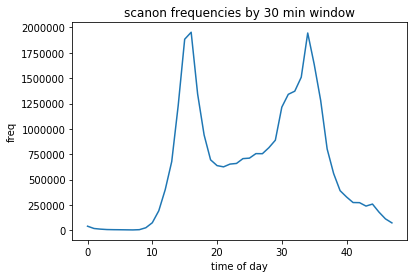

In [20]:
# look at pattern of cards scan on and off by hourly window
myPlt = grp['Freq'].plot()
plt.title('scanon frequencies by 30 min window')
plt.ylabel('freq'), plt.xlabel('time of day');

In [21]:
grp.columns

Index(['Time', 'Minutes', 'Freq', 'Day', 'normFreq', 'Peak'], dtype='object')

In [46]:
grp.sample(10)

,Time,Minutes,CardID,Day1
3,01:30:00,3.0,890,04-Mar-2018
38,19:00:00,38.0,50700,04-Mar-2018
19,09:30:00,19.0,61228,04-Mar-2018
20,10:00:00,20.0,56173,04-Mar-2018
21,10:30:00,21.0,53349,04-Mar-2018
8,04:00:00,8.0,570,04-Mar-2018
4,02:00:00,4.0,664,04-Mar-2018
46,23:00:00,46.0,17530,04-Mar-2018
29,14:30:00,29.0,68588,04-Mar-2018
11,05:30:00,11.0,14110,04-Mar-2018


In [34]:
allGrps['Day'].min()

'04-Mar-2018'

In [31]:
allGrps.sample(10)

,Day,newDateTime,CardID,Minutes,Time
170,07-Mar-2018,2018-03-07 17:00:00,9027,34.0,17:00:00
323,10-Mar-2018,2018-03-10 21:30:00,2416,43.0,21:30:00
23,04-Mar-2018,2018-03-04 15:30:00,2105,31.0,15:30:00
112,06-Mar-2018,2018-03-06 12:00:00,5880,24.0,12:00:00
302,10-Mar-2018,2018-03-10 11:00:00,2571,22.0,11:00:00
284,10-Mar-2018,2018-03-10 02:00:00,171,4.0,02:00:00
184,08-Mar-2018,2018-03-08 00:00:00,105,0.0,00:00:00
253,09-Mar-2018,2018-03-09 10:30:00,2817,21.0,10:30:00
129,06-Mar-2018,2018-03-06 20:30:00,2886,41.0,20:30:00
47,05-Mar-2018,2018-03-05 03:30:00,1,7.0,03:30:00


In [ ]:
# todo add in sunrise/sunset


In [21]:
grp.sample(10)

,Day,DateTime,Freq,normFreq,Minutes
14,04-Mar-2018,2018-03-04 11:00:00,5617,0.176886,660.0
178,07-Mar-2018,2018-03-07 21:00:00,3861,0.121587,1260.0
314,10-Mar-2018,2018-03-10 17:00:00,9324,0.293623,1020.0
54,05-Mar-2018,2018-03-05 07:00:00,19634,0.618296,420.0
215,08-Mar-2018,2018-03-08 15:30:00,20122,0.633664,930.0
259,09-Mar-2018,2018-03-09 13:30:00,9482,0.298599,810.0
71,05-Mar-2018,2018-03-05 15:30:00,19886,0.626232,930.0
279,09-Mar-2018,2018-03-09 23:30:00,2505,0.078885,1410.0
51,05-Mar-2018,2018-03-05 05:30:00,2685,0.084554,330.0
241,09-Mar-2018,2018-03-09 04:30:00,274,0.008629,270.0


In [29]:
grp.columns

Index(['Day', 'ParentRoute', 'newDateTime', 'CardID'], dtype='object')